In [1]:
from hydromt_sfincs import SfincsModel

import geopandas as gpd

In [2]:
root = r"d:\repos\hydromt_sfincs\hydromt_sfincs\examples\sfincs_compound"
sf = SfincsModel(root=root, mode="w+", data_libs=[r"d:\repos\hydromt_sfincs\hydromt_sfincs\examples\italy\data_catalog.yml", "deltares_data"])

Model dir already exists and files might be overwritten: d:\repos\hydromt_sfincs\hydromt_sfincs\examples\sfincs_compound\gis.


In [3]:
sf.setup_grid(
    x0=318650,
    y0=5040000,
    dx=50.0,
    dy=50.0,
    nmax=107,
    mmax=250,
    rotation=27,
    epsg=32633,
)

Create a 500m buffer around the coastline

In [4]:
gdf_osm = sf.data_catalog.get_geodataframe("osm_coastlines", bbox=sf.bbox, buffer=0)

# convert polygon to line
gdf_osm_line = gdf_osm.to_crs(sf.crs).boundary

# add a buffer to the line of 500m 
gdf_osm_buf = gdf_osm_line.buffer(500)

# clip to model extent (whhy again needed?)
gdf_osm_buf = gdf_osm_buf.intersection(sf.region.geometry)

In [5]:

gdf_refinement = gpd.GeoDataFrame(
    {"refinement_level": [1]},#, 2]},
    geometry=[
        gdf_osm_buf.unary_union,
        # gdf_riv_buf.unary_union,
    ],
    crs=sf.crs,
)

sf.setup_grid_from_region(region={"geom": sf.region}, #area that needs to be covered by the grid
                            res=100, # set resolution
                            rotated=True, # when True, rotation is determined to minimize the grid extent
                            refinement_polygons=gdf_refinement)

Building mesh ...
Refining ...
Time elapsed : 0.11852645874023438 s
Finding neighbors ...
Time elapsed : 0.005997180938720703 s
Setting neighbors left and below ...
Time elapsed : 0.01600170135498047 s
Getting uv points ...
Time elapsed : 0.042998313903808594 s
Making XUGrid ...
Got rid of duplicates in 0.2070 seconds
Made XUGrid in 0.0037 seconds
Time elapsed : 0.5058162212371826 s


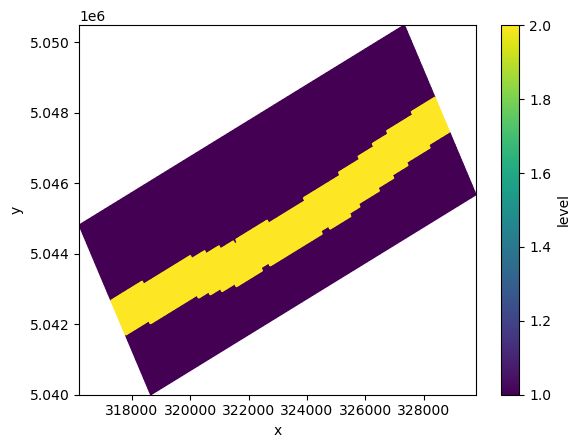

In [6]:
sf.quadtree.data["level"].ugrid.plot()


In [7]:
datasets_dep = [{"elevtn": "merit_hydro", "zmin": 0.001}, {"elevtn": "gebco"}]

sf.setup_dep(datasets_dep=datasets_dep)

In [8]:
sf.quadtree.setup_mask_active(zmin = -7, gdf_include = gdf_osm_buf.unary_union)

In [9]:
sf.setup_mask_bounds(btype="waterlevel", zmax=-4)

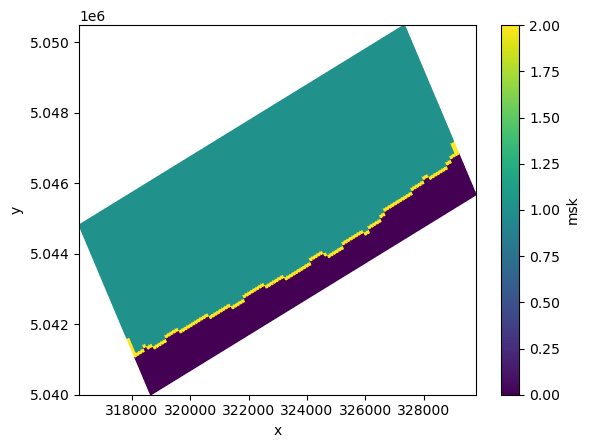

In [10]:
sf.quadtree.data["msk"].ugrid.plot()

## Check the datasets in the example domain

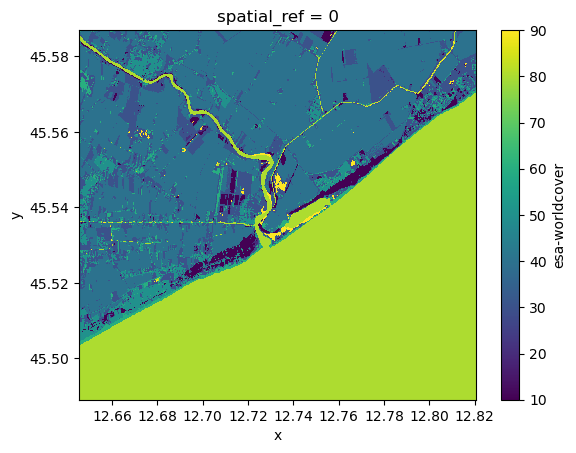

In [11]:
da1 = sf.data_catalog.get_rasterdataset("esa_worldcover", geom=sf.region, buffer=10)
da1.plot()

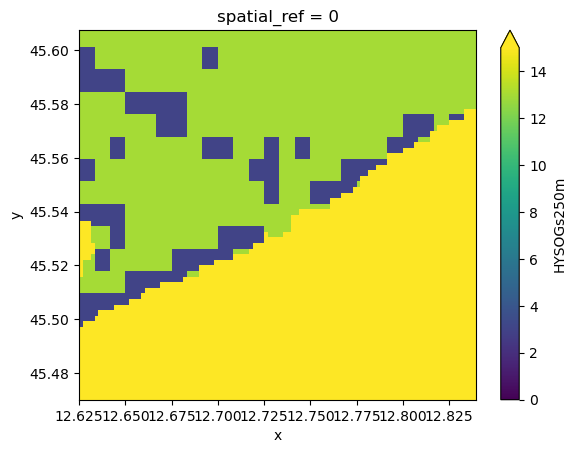

In [12]:
da2 = sf.data_catalog.get_rasterdataset("HYSOGs250m", geom=sf.region, buffer=10)
da2.plot(vmin=0,vmax=15)

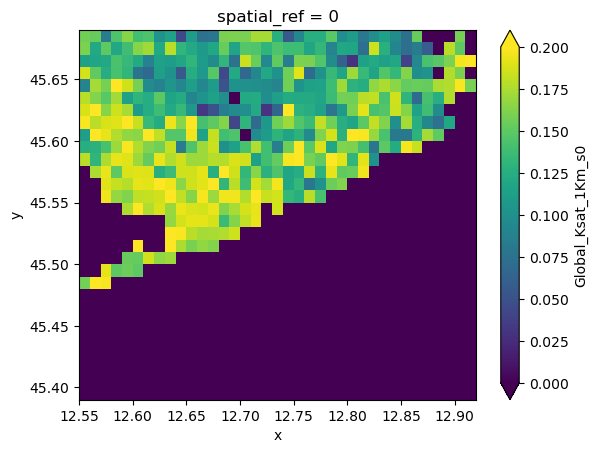

In [13]:
#note that the hydraulic conductivity is already converted from cm/day to micrometer/s (see data_catalog.yml)

da3 = sf.data_catalog.get_rasterdataset("Global_Ksat_1Km_s0", geom=sf.region, buffer=10)
da3.plot(vmin=0, vmax=0.2)

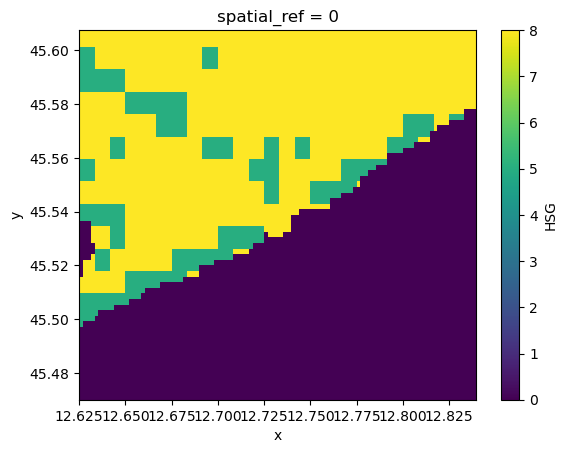

In [14]:
HSG_strings = ["A","B","C","D","A/D","B/D","C/D","D/D", "nan"]
HSG_values = [1,6,5,3,7,2,8,4,0]
HYSOGs250m_values = [1,2,3,4,11,12,13,14,255]


import pandas as pd
df_map = pd.DataFrame({"HYSOGs250m": HYSOGs250m_values, "HSG": HSG_values})
df_map.set_index("HYSOGs250m", inplace=True)

da4 = da2.raster.reclassify(df_map)["HSG"]
da4.raster.set_nodata(0)
da4.plot()

In [15]:
da3.raster.nodata

-3.4e+38

In [17]:
reclass_table = r"d:\repos\hydromt_sfincs\hydromt_sfincs\hydromt_sfincs\data\lulc\esa_worldcover_HSG.csv"

sf.setup_cn_infiltration_with_ks(
    lulc=da1,
    hsg=da4, 
    ksat=da3,
    reclass_table=reclass_table, 
    effective=0.5
    )

No numerical nodata value found, skipping set_nodata


In [18]:
# sf.grid["smax"].plot()#x="xc", y="yc")


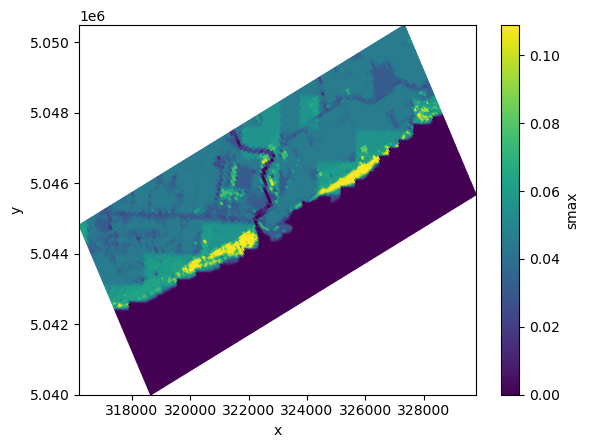

In [19]:
# %matplotlib qt
%matplotlib inline
sf.quadtree.data["smax"].ugrid.plot()
# sf.quadtree.data["smax"].plot()

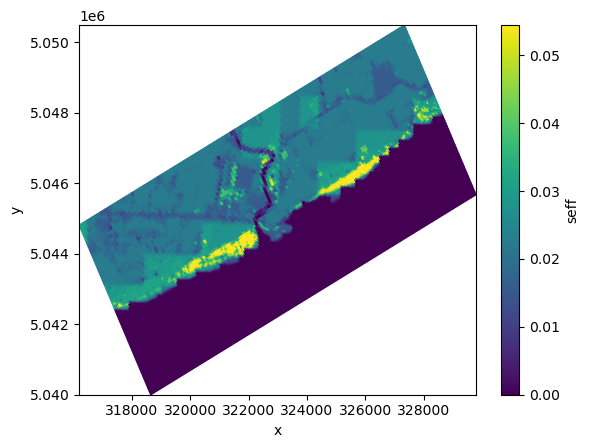

In [20]:
# sf.grid["seff"].plot(x="xc", y="yc")

sf.quadtree.data["seff"].ugrid.plot()

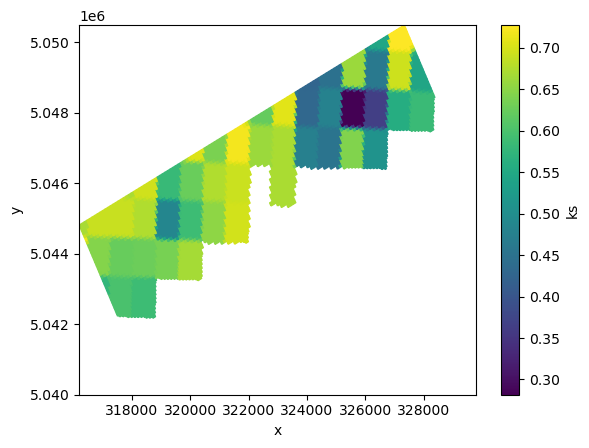

In [21]:
# sf.grid["ks"].plot(x="xc", y="yc")
sf.quadtree.data["ks"].ugrid.plot()

In [27]:
# import importlib
# # from hydromt_sfincs import sfincs
# # importlib.reload(sfincs)
# from hydromt_sfincs import quadtree
# importlib.reload(quadtree)

<module 'hydromt_sfincs.quadtree' from 'D:\\repos\\hydromt_sfincs\\hydromt_sfincs\\hydromt_sfincs\\quadtree.py'>

In [28]:
# TODO 

# add write

sf.write()


TypeError: unhashable type: 'list'